# Predictions on growth of confirmed Novel Coronavirus (2019-nCoV) cases in countries 
                      By Bohan updated on March 29, 2020  
## Goal: Make an educated guess on when the spread of the novel coronavirus will stabilize (i.e. when the things will get better) in different countries

## Method: 
1. Use the data from China as an example to create logistic models for different countries 
2. Use R^2 to evaluate goodness of fit
3. Use inflection point to predict the turning point (i.e. when the number of newly confirmed cases per day will start to decrease)
4. Use 99.9% of the top horizontal asymptote value to predict when the situation wil stablize (i.e. the number of newly confirmed cases is closed to zero)

## Data: 
Publically available source from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE  
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


## Disclaimer: 
### 1. The model assumes that everything stays constant, so the conclusions will be affected both positively and negatively by dramatic changes such as new travel restictions, shortage of health care supplies, ect
### 2. Only confirmed cases were included, so the result depends number of tests done and it does not necessarily reflect the actual infected population in each countries
### 3. I intend to update every week and conclusion may be different in each update (due to new models being generated from latest data)


## Summary: 
### 1. The logistic model was applied to 59 countries
### 2. Mean turning point for these countries is on 2020-03-24 (This is an understimate because only countries close to turning points can be modeled)
### 3. Mean CurveTop for these countries is on 2020-04-21
### 4. The numbers of confirmed cases in US, Spain,	Italy, United Kingdom, Germany, France may exceed those in China
### 5. Comparing to last week, more countries can be modeled by logistic model, indicating that an increase in number of confirmed cases globally and more countries are getting closer to turning points
### 6. By looking at CruveTop and comparing from last week, Gemany reduced future confirmed cases by half. On the other hand, Italy, Spain, and France need to enforce containment measures because the total confirmed cases in the future are predicted to be increasing.
  

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import scipy as sp; # for statistical tests
import matplotlib.pyplot as plt; # for plotting
import seaborn as sns; # for heatmaps

# add custom converters for timestamps when plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# data from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

df = pd.read_csv('time_series_19-covid-Confirmed.csv'); # import file
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


## Create China data frame as an example
The location data and Province/State data will be ignore 

In [3]:
China = df[df['Country/Region'] == 'China'];
China.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,480,491,504,522,537,558,561,566,569,573
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,577,578,578,578,578,578,578
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,296,299,303,313,313,318,322,328,331,337
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,...,134,134,134,136,136,136,136,136,136,136


In [4]:
# calculate sums for the entire country
China_sum = China.iloc[:,4:].sum(axis=0);

## Create logistic model as
## f(x) = a / (1 + e^(-c * (x - d)) ) + b
    where x is time, 
    f(x) is Percentage confirmed cases over entire population,
    a,b,c,d are fitting parameters

### The inflection point is at x =  -ln( abs(1 - 2a/(a-b) )) / c +d
### The horizontal asymptote is f(x) = a + b

In [5]:
# create logistic function
def func(x, a,b,c,d): 
    return a / (1. + np.exp(-c * (x - d))) + b

In [6]:
 # import curve_fit function and fit the curve
from scipy.optimize import curve_fit;
# repeate fitting three time using consecutive parameters
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  0,  0]);
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt);
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt);
y_fit = func(np.arange(len(China_sum)), popt[0],popt[1],popt[2],popt[3]);

In [7]:
# create a function to plot data
def p_model(s, y_fit, name):
    # s: pandas series containing number of confirmed cases
    # name: name of country (str)
    plt.figure(figsize=(20,15));
    plt.plot(s.to_numpy(),'b', label=name);
    plt.plot(y_fit,'r--', label='Simulated');
    plt.legend(fontsize=20);
    plt.ylabel('Number of confirmed cases over entire population', fontsize=20);
    plt.title('Cumulative number of confirmed cases per day', fontsize=20);
    plt.xlabel('Days after first report', fontsize=20);
    plt.show();

In [8]:
# create a function to plot data
def p_model(s, y_fit, name, fst):
    # s: pandas series containing number of confirmed cases
    # y_fit: 1-d array containing model data 
    # name: name of country (str)
    # fst: first day of the data set (str)
    
    plt.figure(figsize=(20,15));
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(s)), unit='day'), s.to_numpy(),'b', label=name);
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(y_fit)), unit='day'), y_fit,'r--', label='Simulated');
    plt.legend(fontsize=20);
    plt.ylabel('Number of confirmed cases over entire population', fontsize=20);
    plt.title('Cumulative number of confirmed cases per day', fontsize=20);
    plt.xlabel('Date', fontsize=20);
    plt.show();

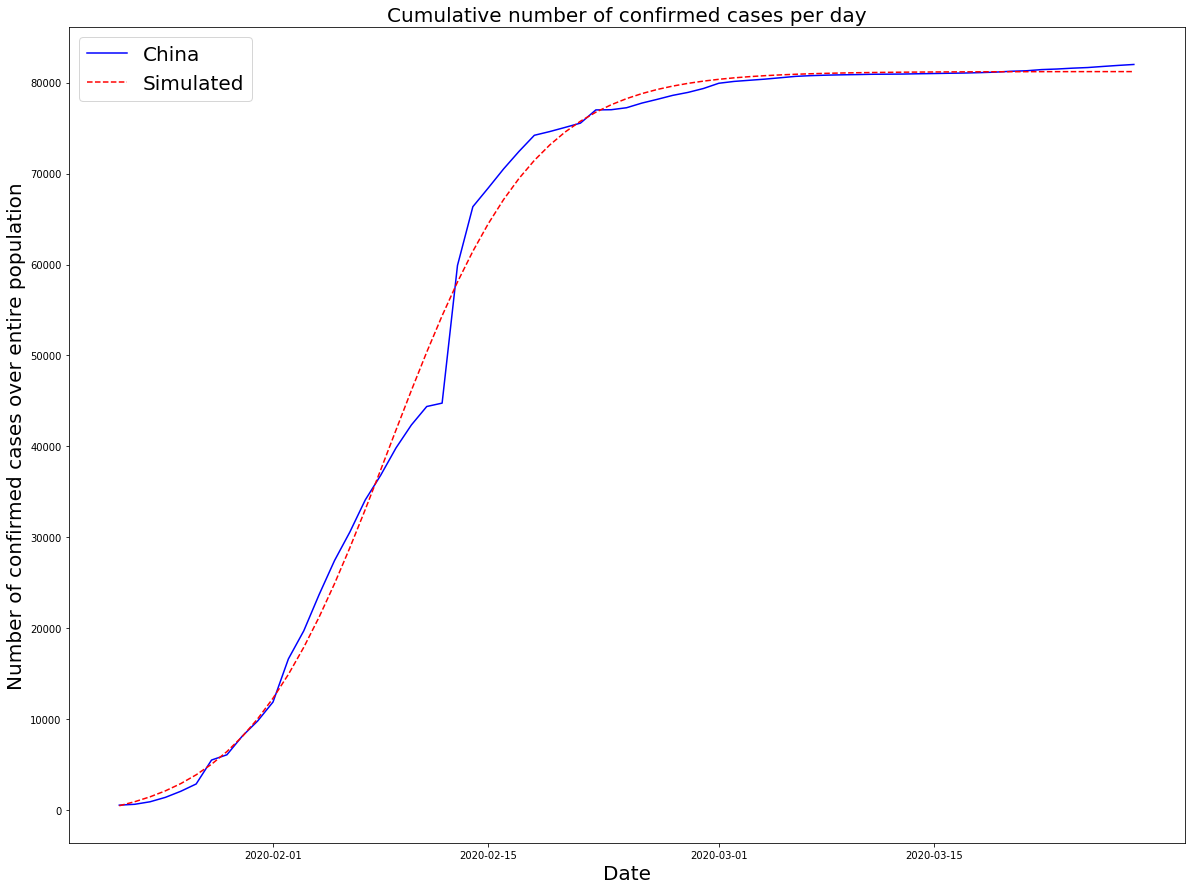

In [9]:
# plot for China
p_model(China_sum, y_fit, 'China', China_sum.index[0])

In [10]:
# define the function to caculate R^2 using residual sum of squares
def r_square(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [11]:
# The closer the R^2 is to 1, the better the fitting
print('R^2 = ', r_square(China_sum.to_numpy(), y_fit))

R^2 =  0.9956956500454792


In [12]:
# find % when the confirmed population stablized on March 18
# the inflection point is at fp = a/2
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(fb-b)))/c + d = -ln(abs(1-2a/(a-b)))/c + d
# caculate this date:
iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
print('The day reaches the turning point is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(iday, unit='day'));

The day reaches the turning point is on:  2020-02-08 17:30:56.097475200


In [13]:
# top horizontal horizontal asymptotes is a + b (popt[0] + popt[1])
# time to reach 99.9% of asymptote is at y_hor = 0.999*(a + b)
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(y_hor-b)))/c + d
# caculate this date:
dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
print('The day reaches the top of the curve is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(dday, unit='day'));
print('The total number of confirmed cases is ', popt[0]+popt[1]);

The day reaches the top of the curve is on:  2020-03-12 01:28:40.447027200
The total number of confirmed cases is  81216.60504460297


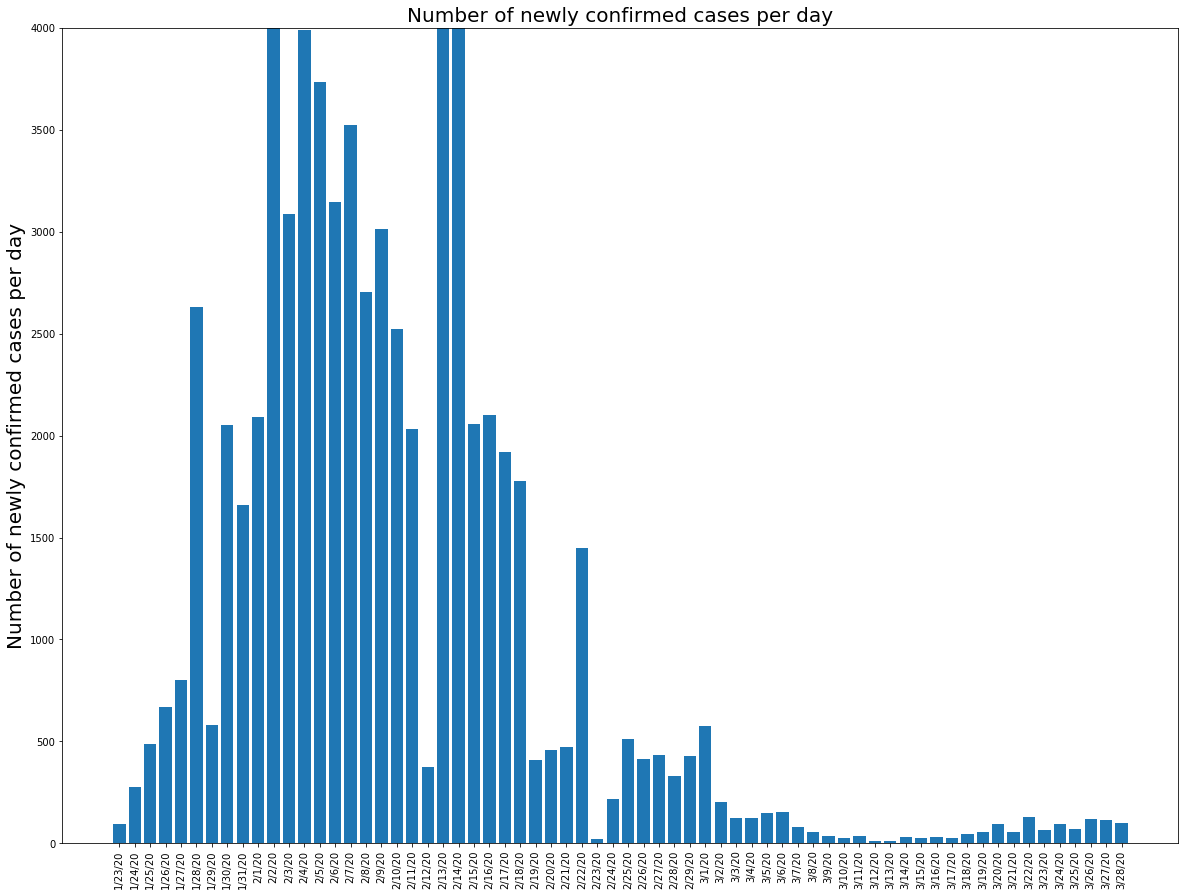

In [14]:
# plot number of newly confirmed cases
plt.figure(figsize=(20,15));
plt.bar(China_sum.index[1:], China_sum.to_numpy()[1:]-China_sum.to_numpy()[:-1]);
plt.xticks(rotation='vertical');
plt.ylim((0,4000));
plt.ylabel('Number of newly confirmed cases per day', fontsize=20);
plt.title('Number of newly confirmed cases per day', fontsize=20);

## Summary:
1. As shown in the bar graph, the number of newly confirmed cases did decrease after 2/7/2020 as perdicted by the model but it increased again on 2/13/2020.
2. After 3/8/2020, the number of newly confirmed cases stablized which closely matches the modelperdiction: 3/11/2020.  
3. Therefore, the model is suitable for making guesses.

# Predictions on Other countries

In [15]:
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  0,  0]);
# fitting parameters for China
popt_china = popt;
# for storing data
POPT = [];
PCOV = [];
R2 = [];
Iday = [];
Dday = [];
NAME = [];
TotalC = [];

# I will ignore number of confirmed cases below 400
# because good model cannot be generated from small sample size
countries = df['Country/Region'].unique()
for ct in np.arange(len(countries)):
    
    # caculate sums per country
    df1 = df[df['Country/Region'] == countries[ct]].iloc[:, 4:].sum(axis=0);
    
    # I will ignore number of confirmed cases below 400
    # because good model cannot be generated from small sample size
    if df1[-1] < 400:
        continue
    
    # try to fit the curve
    try:
        # repeate fitting three time starting with parameters for China
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                               p0= [df1.iloc[-1], popt_china[1],popt_china[2],popt_china[3]]);
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
    except RuntimeError:
        try: 
            # repeate fitting three time starting with zeros
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy());
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
        except RuntimeError:
            continue
    
    # calculate model curve
    y_fit = func(np.arange(len(df1)), popt[0],popt[1],popt[2],popt[3]);
    
    # calculate R^2
    # The closer the R^2 is to 1, the better the fitting
    r2 = r_square(df1.to_numpy(), y_fit);
    
    # ignore if R^2 value is less than 0.98 or above one (indeicating poor fits)
    if r2 < 0.98 or r2 > 1:
        continue
    
    # print country name
    print(countries[ct]);
        
    # print R^2
    print('R^2 = ', r2);
    
    # caculate turning point
    iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
    print('The day reaches the turning point is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    
    # caculate date reaches mzx:
    dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
    print('The day reaches the top of the curve is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    print('The total number of confirmed cases is ', popt[0]+popt[1]);
    
    # save data
    POPT.append(popt);
    PCOV.append(pcov);
    R2.append(r2);
    Iday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    Dday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    TotalC.append(popt[0]+popt[1]);
    NAME.append(countries[ct]);
    
# convert to numpy array
POPT = np.array(POPT);
PCOV = np.array(PCOV);
R2 = np.array(R2);

Algeria
R^2 =  0.9960356738816791
The day reaches the turning point is on:  2020-03-26 21:44:30.825139200
The day reaches the top of the curve is on:  2020-04-23 04:20:35.667513599
The total number of confirmed cases is  807.7558528513899
Argentina
R^2 =  0.9957828788673617
The day reaches the turning point is on:  2020-03-27 15:03:52.585084800
The day reaches the top of the curve is on:  2020-04-21 23:10:12.802598400
The total number of confirmed cases is  1297.4233297367289
Armenia
R^2 =  0.9919099121633442
The day reaches the turning point is on:  2020-03-23 16:17:59.439984
The day reaches the top of the curve is on:  2020-04-17 16:46:19.095427200
The total number of confirmed cases is  482.9709274988847
Australia
R^2 =  0.9986076288145566
The day reaches the turning point is on:  2020-03-26 21:41:47.999500800
The day reaches the top of the curve is on:  2020-04-22 09:21:35.411616
The total number of confirmed cases is  6322.887412483262
Austria
R^2 =  0.9988855291738385
The day rea

C:\Users\erwin\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Brazil
R^2 =  0.9983524120115934
The day reaches the turning point is on:  2020-03-24 17:29:41.421004800
The day reaches the top of the curve is on:  2020-04-13 20:04:18.854371200
The total number of confirmed cases is  5053.335124782285
Canada
R^2 =  0.9989735697948432
The day reaches the turning point is on:  2020-03-28 06:42:35.764272
The day reaches the top of the curve is on:  2020-04-21 10:19:40.446076800
The total number of confirmed cases is  11598.93668818788
Chile
R^2 =  0.9981363774150996
The day reaches the turning point is on:  2020-03-29 02:18:21.050035200
The day reaches the top of the curve is on:  2020-04-24 22:28:25.526352
The total number of confirmed cases is  4383.628007584904
China
R^2 =  0.9956956500454792
The day reaches the turning point is on:  2020-02-08 17:30:56.095833599
The day reaches the top of the curve is on:  2020-03-12 01:28:40.476576
The total number of confirmed cases is  81216.60507821623
Colombia
R^2 =  0.9974536556705608
The day reaches the turn

C:\Users\erwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Ireland
R^2 =  0.9979042428797076
The day reaches the turning point is on:  2020-03-26 08:20:40.981315200
The day reaches the top of the curve is on:  2020-04-20 18:00:39.828067200
The total number of confirmed cases is  3899.8574913574794
Israel
R^2 =  0.9903813333998438
The day reaches the turning point is on:  2020-03-27 15:44:05.914377599
The day reaches the top of the curve is on:  2020-04-17 10:04:17.403945600
The total number of confirmed cases is  6940.936468967254
Italy
R^2 =  0.9995838884870634
The day reaches the turning point is on:  2020-03-22 16:54:21.903984
The day reaches the top of the curve is on:  2020-04-28 09:02:51.203760
The total number of confirmed cases is  124845.06737629129
Japan
R^2 =  0.9936749437590159
The day reaches the turning point is on:  2020-04-01 09:32:39.733353600
The day reaches the top of the curve is on:  2020-06-29 11:57:58.448419200
The total number of confirmed cases is  3715.8857244607793
Korea, South
R^2 =  0.9966218942023676
The day reach

In [16]:
print('Number of Countries: ', len(NAME));
Pred = pd.DataFrame(data = {'Country/Region': NAME, 'R^2': R2, 'TurningP': Iday, 'CurveTop': Dday, 'TotalConfirmed': TotalC})
Pred.sort_values(by=['TotalConfirmed'], ascending=False).style.bar(subset=['TotalConfirmed'])

Number of Countries:  59


,Country/Region,R^2,TurningP,CurveTop,TotalConfirmed
58,US,0.999457,2020-03-28 02:46:20.946835200,2020-04-19 09:49:06.110572800,246061
52,Spain,0.999043,2020-03-28 14:00:48.367036800,2020-04-28 18:39:11.883513599,157666
28,Italy,0.999584,2020-03-22 16:54:21.903984,2020-04-28 09:02:51.203760,124845
57,United Kingdom,0.998877,2020-04-05 01:50:45.598560,2020-05-08 03:50:19.721472,110857
20,Germany,0.997976,2020-03-27 11:53:23.226230400,2020-04-27 23:40:25.289961600,107137
19,France,0.999156,2020-03-29 09:25:41.181600,2020-05-04 11:52:01.241356800,86742.3
9,China,0.995696,2020-02-08 17:30:56.095833599,2020-03-12 01:28:40.476576,81216.6
56,Turkey,0.996025,2020-04-02 03:33:54.637574400,2020-04-20 19:57:49.076323200,57730.7
47,Russia,0.998785,2020-04-14 10:59:43.904342400,2020-05-16 08:38:53.759270400,56799.6
42,Philippines,0.994923,2020-04-16 00:18:05.500742400,2020-05-25 23:24:10.835683200,28569.7


In [17]:
print('Mean turning point for these countries is ', Pred['TurningP'].mean());
print('Mean CurveTop for these countries is ', Pred['CurveTop'].mean());

Mean turning point for these countries is  2020-03-24 10:17:34.600839168
Mean CurveTop for these countries is  2020-04-21 03:06:48.019382784


## Examples

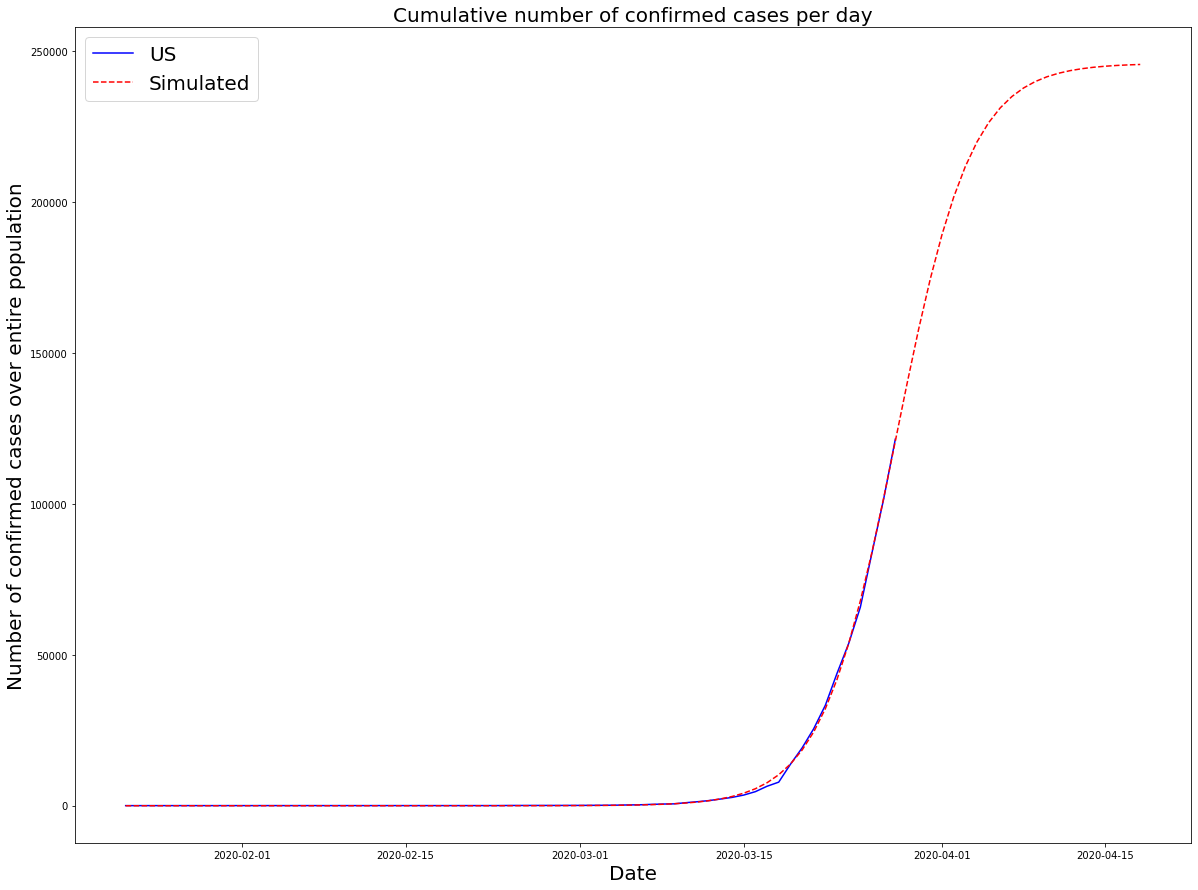

In [22]:
# US
example = 'US';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

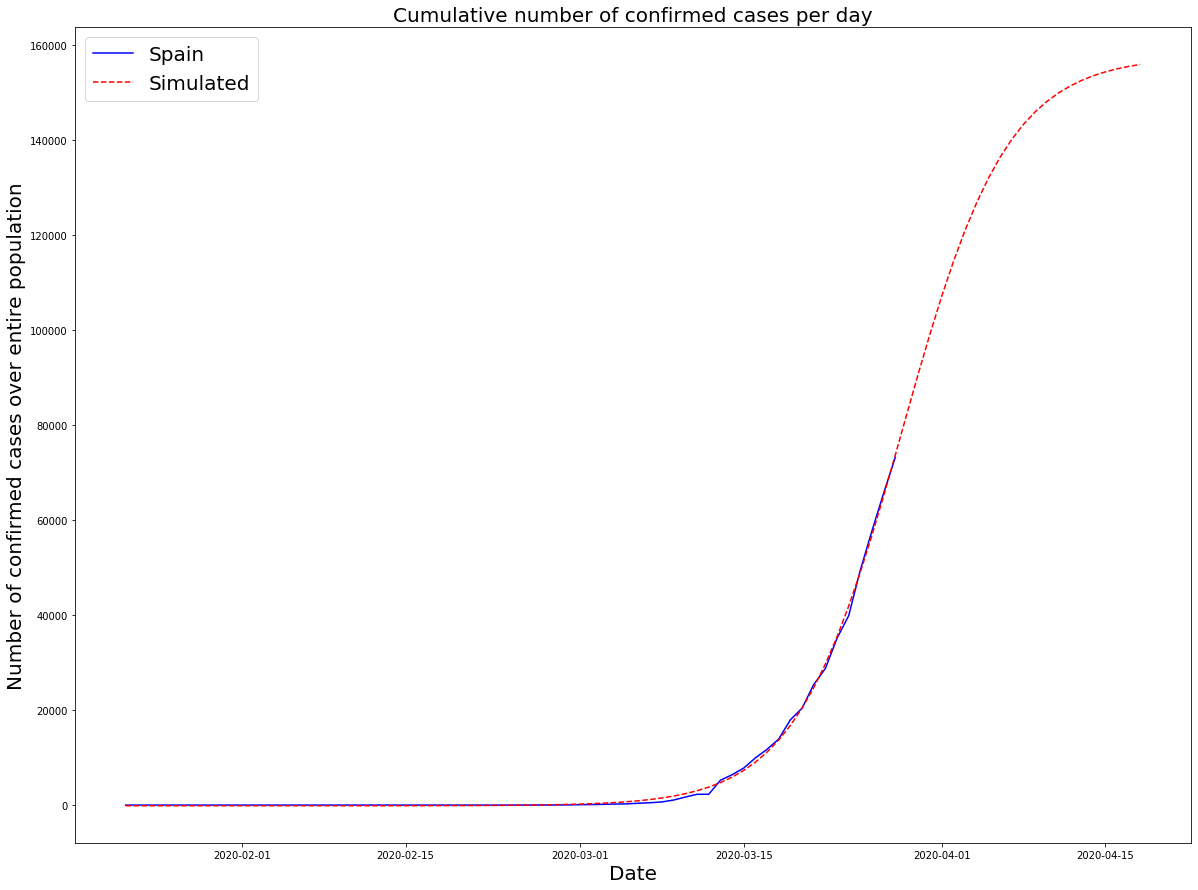

In [23]:
# Spain
example = 'Spain';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

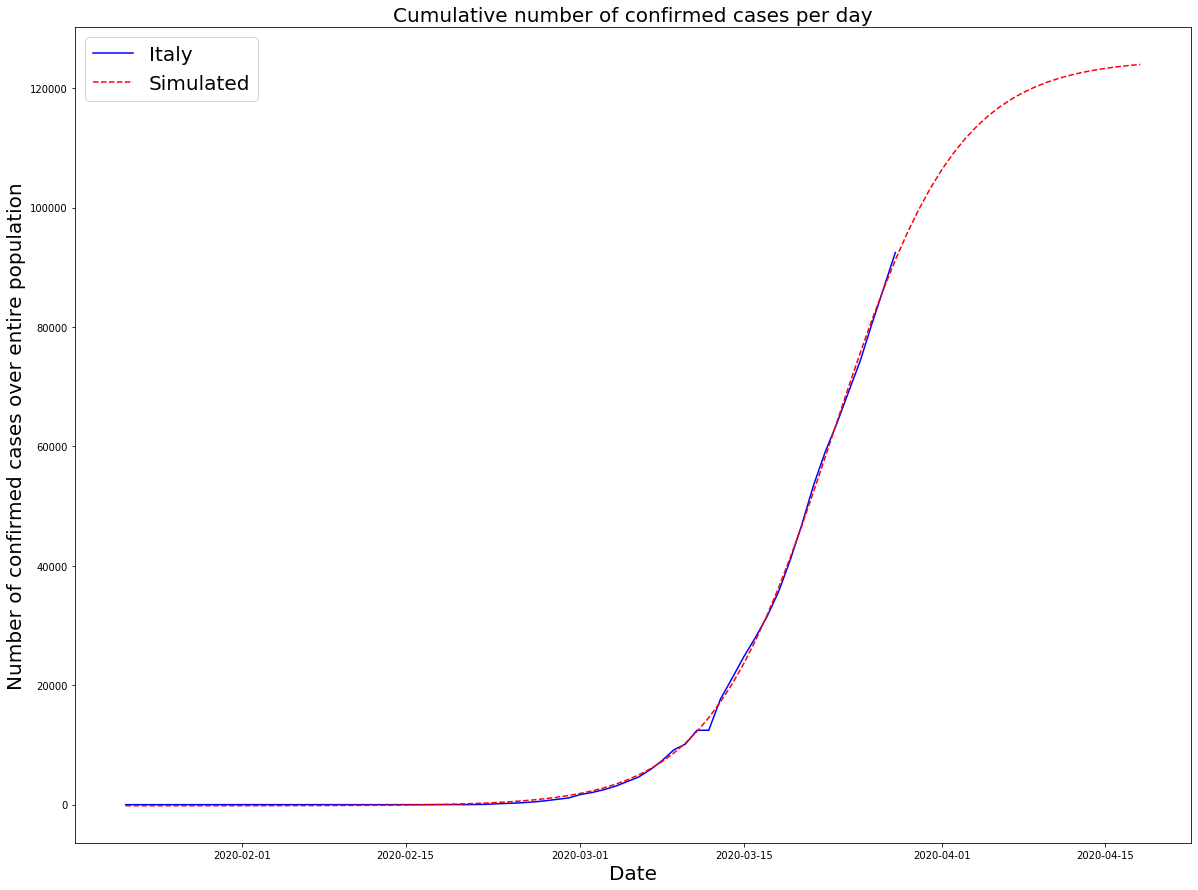

In [19]:
# Italy
example = 'Italy';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

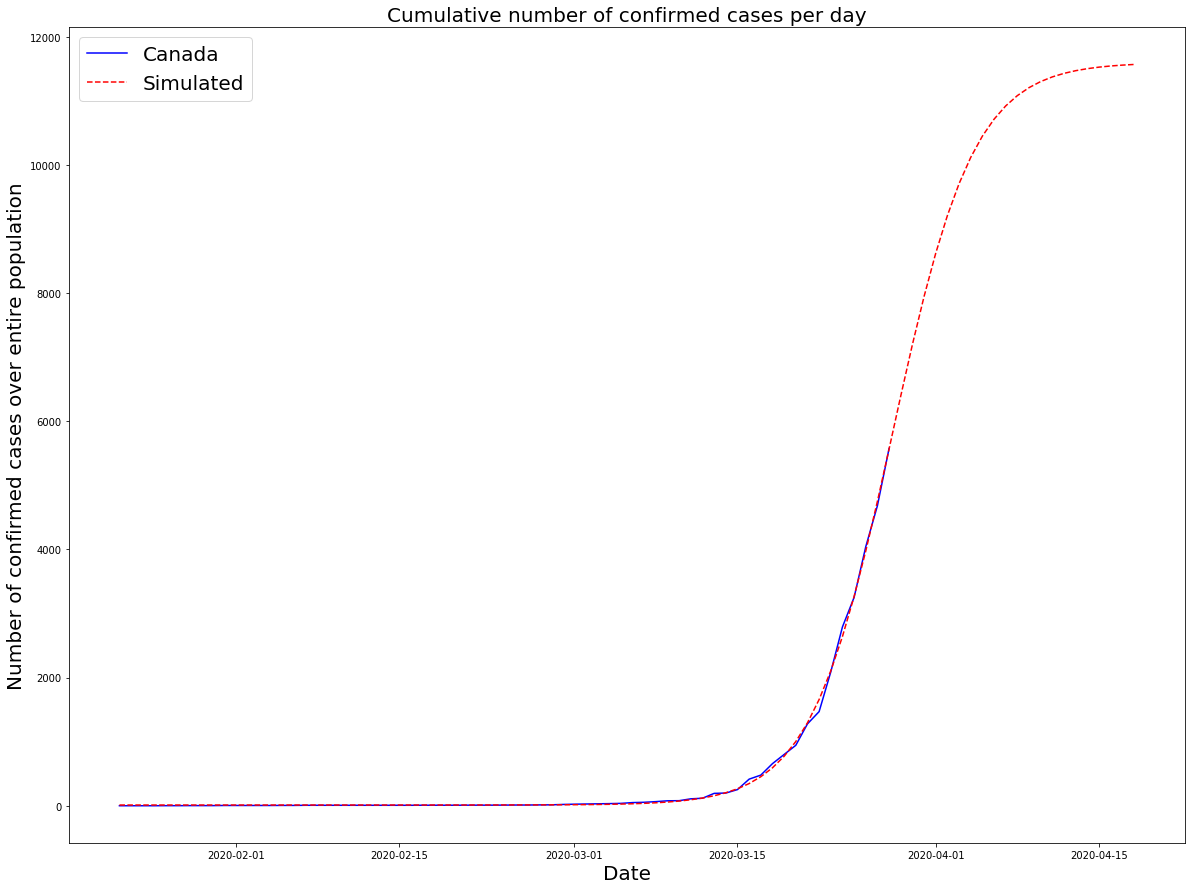

In [20]:
# Canada
example = 'Canada';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);